Este es el script de código que entrena el modelo con __regresión lineal__ para predecir el __precio mínimo__. El entrenamiento se ha realizado siguiendo varias <u>estrategias</u>:

- Modelo base sin escalar
    - Todo el conjunto
    - Solo variables numéricas
- Modelo base con escalado de variables numéricas
    - bucle manual con standard scaler
    - bucle manual con robust scaler
    - pipeline con robust scaler y column transformer
> Aunque los resultados con el escalado parecen algo mejores, las técnicas de búsqueda se han hecho sin escalar.
- Búsqueda de mejor combinación de parámetros con GridSearchCV
- Búsqueda de mejor combinación de parámetros con RandomizedSearchCV
> En regularización, sin embargo, se emplee un método u otro siempre hay que estandarizar o normalizar los predictores. Hecho con Robust Scaler.
- Regularización con Ridge buscando el mejor valor de alpha
    - Ridge sin escalar
    - Ridge escalando con RobustScaler()
- Regularización con Lasso buscando el mejor valor de alpha
- Regularización con Elastic Net buscando los mejores valores de lambda y alpha


Para todos ellos, se han calculado las <u>métricas</u>:
- MAPE (Mean Absolute Percentage Error)
- MSE (Mean Squared Error)
- RMSE (Root Mean Squared Error)

Además, para todos ellos, se han calculado los <u>coeficientes</u> del modelo ajustado y mostrado en una gráfica.

Al final del script hay una <u>tabla resumen</u> que reúne todas las <u>métricas</u>, <u>tiempos de ejecución</u> y <u>otros valores importantes</u> para cada versión del algoritmo de regresión lineal.


## INSTALACIÓN DE LIBRERÍAS Y MLFLOW

In [9]:
#!pip install mlflow

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

In [2]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')

## LECTURA Y PREPROCESADO DE LOS DATOS

In [4]:
import pandas as pd
datos= pd.read_parquet('minEstratificado.parquet')
datos

,name,EventStartTime,SalesStartTIme,SalesEndTime,min_price,nameArtist,VenueName,VenueCity,VenueState,num_links,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,"30 Aniversario de Sôber, con Savia y Skizoo",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,28.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
1,"30 Aniversario de Sôber, con Savia y Skizoo | ...",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,50.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
2,AC/DC - Power Up Tour,2024-05-25 19:00:00+00:00,2024-01-31 11:00:00+00:00,2024-05-25 19:00:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,115,0,1,0
3,AC/DC - Power Up Tour,2024-05-29 19:30:00+00:00,2024-02-16 09:00:00+00:00,2024-05-29 19:30:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,103,0,1,0
4,AC/DC - Power Up Tour,2024-12-14 20:00:00+00:00,2024-03-01 11:00:00+00:00,2024-12-14 20:00:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,288,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Yung Sarria,2024-03-30 20:00:00+00:00,2023-10-06 13:00:00+00:00,2024-03-30 20:00:00+00:00,12.0,Yung Sarria,Sala Shoko,Madrid,Madrid,0,...,0,0,1,0,0,0,176,0,1,3
490,ZENOBIA + DEBLER,2024-06-01 19:30:00+00:00,2024-02-20 09:00:00+00:00,2024-06-01 19:30:00+00:00,22.0,Zenobia,Sala Shoko,Madrid,Madrid,1,...,0,0,0,0,0,0,102,0,1,3
491,gREAT sTRAITS,2024-10-19 19:30:00+00:00,2024-01-02 11:00:00+00:00,2024-10-19 19:30:00+00:00,35.0,gREAT sTRAITS,Sala Razzmatazz 1,Barcelona,Barcelona,0,...,0,0,0,0,0,0,291,0,1,3
492,gREAT sTRAITS,2024-09-13 19:30:00+00:00,2023-12-22 09:00:00+00:00,2024-09-13 19:30:00+00:00,38.0,gREAT sTRAITS,La Riviera,Madrid,Madrid,0,...,0,0,0,0,0,0,266,0,1,3


In [13]:
len(datos.columns)

67

In [14]:
datos['fold']

0      0
1      0
2      0
3      0
4      0
      ..
489    3
490    3
491    3
492    3
493    3
Name: fold, Length: 494, dtype: int64

In [5]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados']

datos.drop(columnas, axis=1, inplace=True)

In [16]:
datos

,min_price,num_links,seguidoresSpotify,popularidad,subsYT,VenueClass,NumGeneros,peso_promotor,tiene_lastfm_url,conciertos_del_artista_en_ciudad,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,28.0,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,...,0,0,0,0,0,0,85,0,1,0
1,50.0,1,4.564084e+06,60.904615,1.716398e+06,2,1,22,0,2.0,...,0,0,0,0,0,0,85,0,1,0
2,105.0,10,2.797956e+07,82.000000,1.716398e+06,3,3,85,1,4.0,...,0,0,0,0,1,1,115,0,1,0
3,105.0,10,2.797956e+07,82.000000,1.716398e+06,3,3,85,1,4.0,...,0,0,0,0,1,1,103,0,1,0
4,105.0,10,2.797956e+07,82.000000,1.716398e+06,3,3,85,1,4.0,...,0,0,0,0,1,1,288,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,12.0,0,4.564084e+06,60.904615,1.716398e+06,0,1,3,0,1.0,...,0,0,1,0,0,0,176,0,1,3
490,22.0,1,4.564084e+06,60.904615,1.716398e+06,0,1,8,0,1.0,...,0,0,0,0,0,0,102,0,1,3
491,35.0,0,4.564084e+06,60.904615,1.716398e+06,0,1,2,0,1.0,...,0,0,0,0,0,0,291,0,1,3
492,38.0,0,4.564084e+06,60.904615,1.716398e+06,1,1,2,0,1.0,...,0,0,0,0,0,0,266,0,1,3


In [6]:
columnas_a_escalar = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches'] # las numéricas

In [7]:
# División de los datos en X e y
# ==============================================================================
# RANDOM_STATE = 83 #fijamos la semilla que no hace falta en nuestro estudio

X = datos.drop(columns=['min_price', 'fold'])
y = datos['min_price']

In [19]:
print(X)
print(y)

     num_links  seguidoresSpotify  popularidad        subsYT  VenueClass  \
0            1       4.564084e+06    60.904615  1.716398e+06           2   
1            1       4.564084e+06    60.904615  1.716398e+06           2   
2           10       2.797956e+07    82.000000  1.716398e+06           3   
3           10       2.797956e+07    82.000000  1.716398e+06           3   
4           10       2.797956e+07    82.000000  1.716398e+06           3   
..         ...                ...          ...           ...         ...   
489          0       4.564084e+06    60.904615  1.716398e+06           0   
490          1       4.564084e+06    60.904615  1.716398e+06           0   
491          0       4.564084e+06    60.904615  1.716398e+06           0   
492          0       4.564084e+06    60.904615  1.716398e+06           1   
493          0       4.564084e+06    60.904615  1.716398e+06           2   

     NumGeneros  peso_promotor  tiene_lastfm_url  \
0             1             22     

### Uso de __cross_validate__ para hacer la validación cruzada:

Si bien __cross_val_score__ es la función por defecto para realizar la validación cruzada y devolver la métrica que se quiere calcular gracias al atributo cv_returns de esta función, en nuestro código, como no tenemos una sino 3 métricas, Python recomienda mejor el uso de __cross_validate__.

En la función cross_validate de scikit-learn, no existe un atributo llamado cv_returns para obtener las métricas directamente. Sin embargo, se puede acceder a las métricas calculadas durante la validación cruzada utilizando la salida de la función cross_validate. Esta salida es un diccionario que contiene varias claves, incluyendo las métricas calculadas para cada división de los datos de entrenamiento y prueba.

Por ejemplo, si se tiene configurado scoring para calcular el MAPE, MSE y RMSE, se puede acceder a estas métricas utilizando las claves test_mape, test_mse y test_rmse para el conjunto de prueba, y train_mape, train_mse y train_rmse para el conjunto de entrenamiento.

Función que carga un modelo en MLFLOW. Recibe como parámetros el modelo, el nombre del experimento y el nombre del run.

In [8]:
import mlflow

def cargar_modelo_mlflow(modelo, experimento, run_name, results, time):

    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("results.csv", index=False)

    # Iniciar un nuevo run de MLflow
    with mlflow.start_run(run_name=run_name):

        # Configurar el experimento de MLflow
        mlflow.set_experiment(experimento)

        #mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_params(modelo.get_params())
        mlflow.log_metric("execution_time", time)

        mlflow.sklearn.log_model(modelo, "model")

        # Registrar el archivo CSV en MLflow
        mlflow.log_artifact("results.csv", "results")

    mlflow.end_run()


Función para guardar los resultados en un formato especifico.

In [9]:
# Para el método cross_validate()

def crear_tabla_resultados(resultados):
    # Crear un DataFrame con los resultados de validación cruzada
    df = pd.DataFrame(resultados)
    df = df.drop(columns=['estimator'])

    # Calcular promedios
    promedio = df.mean()

    # Crear DataFrame sin la fila de promedio
    df_sin_promedio = pd.DataFrame({
        'Test Fold': range(0, len(resultados['test_mape'])),
        'MAPE Train': resultados['train_mape'],
        'RMSE Train': resultados['train_rmse'],
        'MSE Train': resultados['train_mse'],
        'MAPE Val': resultados['test_mape'],
        'RMSE Val': resultados['test_rmse'],
        'MSE Val': resultados['test_mse'],
    })

    # Crear DataFrame con la fila de promedio
    df_promedio = pd.DataFrame({
        'Test Fold': ['Promedio'],
        'MAPE Train': promedio['train_mape'],
        'RMSE Train': promedio['train_rmse'],
        'MSE Train': promedio['train_mse'],
        'MAPE Val': promedio['test_mape'],
        'RMSE Val': promedio['test_rmse'],
        'MSE Val': promedio['test_mse'],
    }, index=[len(resultados['test_mape'])])  # Usamos el índice len(resultados['test_MAPE']) para colocar la fila de promedio al final

    # Concatenar los DataFrames
    df_final = pd.concat([df_sin_promedio, df_promedio])

    return df_final

## MODELO BASE SIN ESCALAR

Tiempo de ejecución: 0.09035062789916992 segundos


2024/06/10 19:17:27 INFO mlflow.tracking.fluent: Experiment with name 'MIN_PRICE' does not exist. Creating a new experiment.


MAPE scores por iteración (entrenamiento): [0.19918105 0.19008133 0.18580847 0.17946441]
MAPE scores por iteración (validación): [0.31159593 0.36840427 0.25131212 0.34778106]

MSE scores por iteración (entrenamiento): [132.28319144 132.33449662  83.94829467  96.7761374 ]
MSE scores por iteración (validación): [229.78588341 169.23377247 435.29398501 636.98605696]

RMSE scores por iteración (entrenamiento): [11.50144302 11.50367318  9.1623302   9.83748634]
RMSE scores por iteración (validación): [15.15869003 13.00898814 20.86370018 25.23858271]

Promedio de métricas (entrenamiento):
  MAPE: 0.1886338159248249
  MSE: 111.33553003252403
  RMSE: 10.501233182281245

Promedio de métricas (validación):
  MAPE: 0.319773346293076
  MSE: 367.8249244595045
  RMSE: 18.567490262815923


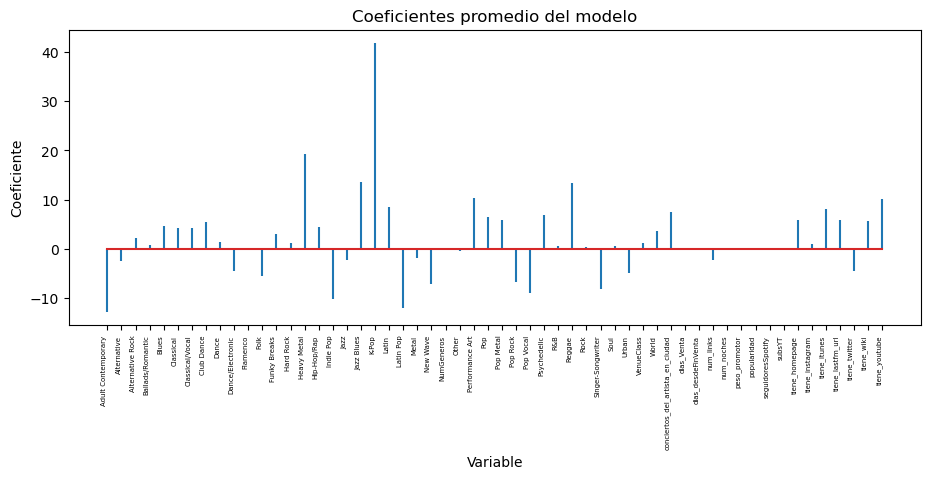

In [10]:
import pandas as pd
from sklearn.model_selection import cross_validate, PredefinedSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time

# Tiempo de inicio de la ejecución
start_time = time.time()

# Definir el modelo
modelo = LinearRegression()

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error'
}

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_validate(modelo, X, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Crear una tabla con los resultados
resultados = crear_tabla_resultados(scores)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo base sin escalar', resultados, execution_time)

# Obtener los resultados de la validación cruzada para cada iteración
train_mape_scores = -scores['train_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
train_mse_scores = -scores['train_mse']
train_rmse_scores = -scores['train_rmse']

test_mape_scores = -scores['test_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
test_mse_scores = -scores['test_mse']
test_rmse_scores = -scores['test_rmse']

# Imprimir los resultados para cada iteración
print("MAPE scores por iteración (entrenamiento):", train_mape_scores)
print("MAPE scores por iteración (validación):", test_mape_scores)

print("\nMSE scores por iteración (entrenamiento):", train_mse_scores)
print("MSE scores por iteración (validación):", test_mse_scores)

print("\nRMSE scores por iteración (entrenamiento):", train_rmse_scores)
print("RMSE scores por iteración (validación):", test_rmse_scores)

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_mape_scores)
train_mse_mean = np.mean(train_mse_scores)
train_rmse_mean = np.mean(train_rmse_scores)

test_mape_mean = np.mean(test_mape_scores)
test_mse_mean = np.mean(test_mse_scores)
test_rmse_mean = np.mean(test_rmse_scores)

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

# Obtener los coeficientes del modelo entrenado en cada iteración
all_coefs = [pd.DataFrame({'predictor': X.columns, 'coef': est.coef_}) for est in scores['estimator']]

# Calcular los coeficientes promedio
average_coefs = pd.concat(all_coefs).groupby('predictor')['coef'].mean()

# Crear la gráfica de barras para los coeficientes promedio
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(average_coefs.index, average_coefs.values, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes promedio del modelo')
plt.show()


| Métrica                 | MAPE (entrenamiento) | MAPE (validación) | MSE (entrenamiento) | MSE (validación) | RMSE (entrenamiento) | RMSE (validación) |
|-------------------------|----------------------|-------------------|---------------------|------------------|----------------------|-------------------|
| Iteración 1             | 0.199                | 0.312             | 132.283             | 229.786          | 11.501               | 15.159            |
| Iteración 2             | 0.190                | 0.368             | 132.334             | 169.234          | 11.504               | 13.009            |
| Iteración 3             | 0.186                | 0.251             | 83.948              | 435.294          | 9.162                | 20.864            |
| Iteración 4             | 0.179                | 0.348             | 96.776              | 636.986          | 9.837                | 25.239            |
| **Promedio**            | **0.189**            | **0.320**         | **111.336**         | **367.825**      | **10.501**           | **18.567**        |

**Tiempo de ejecución**: 0.07301759719848633 segundos


In [11]:
import plotly.express as px

# Obtener las predicciones y los valores verdaderos
predicciones = []
observados = []

for train_index, test_index in ps.split():
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    predicciones.extend(y_pred)
    observados.extend(y_test)

# Crear un DataFrame con los precios reales, predichos y el nombre del concierto (u otra categoría si aplica)
df = pd.DataFrame({'Precio Real': observados, 'Precio Predicho': predicciones})

# Crear un scatter plot interactivo con Plotly
fig = px.scatter(df, x='Precio Real', y='Precio Predicho',
                 title='Comparación de Precios Reales vs Precios Predichos (Regresión Lineal)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agregar una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
              x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el scatter plot interactivo
fig.show()

A diferencia de los precios máximos, los precios mínimos parecen ser más homogéneos y por eso los errores promedio no sufren tanto ni son tan elevados, pues no hay muchos casos de valores atípicos en los datos que eleven estos errores tantísimo.

Como último paso, vamos a probar a hacer el modelo base usando solo las variables numéricas, para decidir si tiene sentido utilizar todas las variables o solo las numéricas.

In [12]:
X_numericas = X[columnas_a_escalar]
X_numericas


,num_links,seguidoresSpotify,popularidad,subsYT,NumGeneros,peso_promotor,conciertos_del_artista_en_ciudad,dias_Venta,dias_desdeFinVenta,num_noches
0,1,4.564084e+06,60.904615,1.716398e+06,1,22,2.0,85,0,1
1,1,4.564084e+06,60.904615,1.716398e+06,1,22,2.0,85,0,1
2,10,2.797956e+07,82.000000,1.716398e+06,3,85,4.0,115,0,1
3,10,2.797956e+07,82.000000,1.716398e+06,3,85,4.0,103,0,1
4,10,2.797956e+07,82.000000,1.716398e+06,3,85,4.0,288,0,1
...,...,...,...,...,...,...,...,...,...,...
489,0,4.564084e+06,60.904615,1.716398e+06,1,3,1.0,176,0,1
490,1,4.564084e+06,60.904615,1.716398e+06,1,8,1.0,102,0,1
491,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,291,0,1
492,0,4.564084e+06,60.904615,1.716398e+06,1,2,1.0,266,0,1


Tiempo de ejecución: 0.04876232147216797 segundos
MAPE scores por iteración (entrenamiento): [0.30040954 0.29803259 0.28445095 0.27809663]
MAPE scores por iteración (validación): [0.31724374 0.36581654 0.26168223 0.37525309]

MSE scores por iteración (entrenamiento): [206.90292035 213.81963562 161.48404788 161.76849928]
MSE scores por iteración (validación): [190.37106955 178.50412706 404.32416887 613.59885216]

RMSE scores por iteración (entrenamiento): [14.38412042 14.62257281 12.70763738 12.7188246 ]
RMSE scores por iteración (validación): [13.79750229 13.36054367 20.10781363 24.77092756]

Promedio de métricas (entrenamiento):
  MAPE: 0.2902474268088028
  MSE: 185.99377578152703
  RMSE: 13.608288805283099

Promedio de métricas (validación):
  MAPE: 0.3299988989600021
  MSE: 346.69955441038366
  RMSE: 18.009196786778247


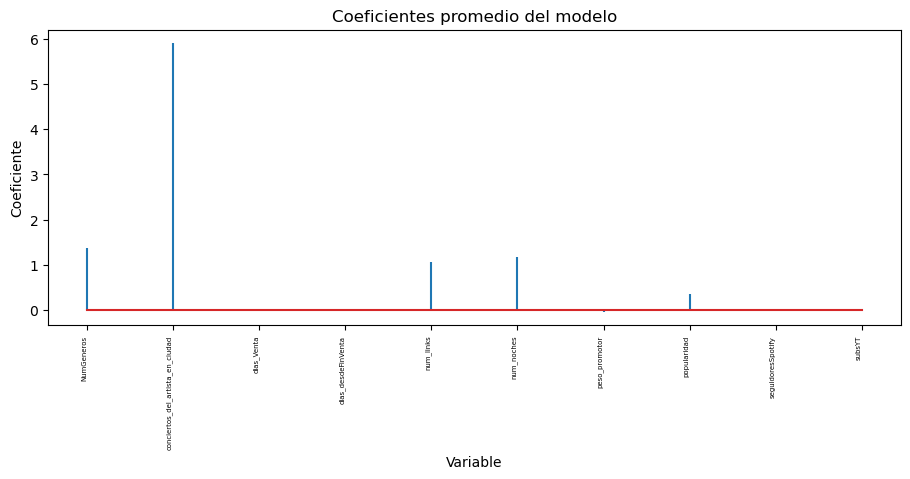

In [13]:
import pandas as pd
from sklearn.model_selection import cross_validate, PredefinedSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time

# Tiempo de inicio de la ejecución
start_time = time.time()

# Definir el modelo
modelo = LinearRegression()

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error'
}

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_validate(modelo, X_numericas, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Crear una tabla con los resultados
resultados = crear_tabla_resultados(scores)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo base sin escalar solo variables numéricas', resultados, execution_time)

# Obtener los resultados de la validación cruzada para cada iteración
train_mape_scores = -scores['train_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
train_mse_scores = -scores['train_mse']
train_rmse_scores = -scores['train_rmse']

test_mape_scores = -scores['test_mape']  # Como utilizamos greater_is_better=False, invertimos el signo
test_mse_scores = -scores['test_mse']
test_rmse_scores = -scores['test_rmse']

# Imprimir los resultados para cada iteración
print("MAPE scores por iteración (entrenamiento):", train_mape_scores)
print("MAPE scores por iteración (validación):", test_mape_scores)

print("\nMSE scores por iteración (entrenamiento):", train_mse_scores)
print("MSE scores por iteración (validación):", test_mse_scores)

print("\nRMSE scores por iteración (entrenamiento):", train_rmse_scores)
print("RMSE scores por iteración (validación):", test_rmse_scores)

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_mape_scores)
train_mse_mean = np.mean(train_mse_scores)
train_rmse_mean = np.mean(train_rmse_scores)

test_mape_mean = np.mean(test_mape_scores)
test_mse_mean = np.mean(test_mse_scores)
test_rmse_mean = np.mean(test_rmse_scores)

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

# Obtener los coeficientes del modelo entrenado en cada iteración
all_coefs = [pd.DataFrame({'predictor': X_numericas.columns, 'coef': est.coef_}) for est in scores['estimator']]

# Calcular los coeficientes promedio
average_coefs = pd.concat(all_coefs).groupby('predictor')['coef'].mean()

# Crear la gráfica de barras para los coeficientes promedio
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(average_coefs.index, average_coefs.values, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficiente')
ax.set_title('Coeficientes promedio del modelo')
plt.show()



| Métrica             | MAPE (entrenamiento) | MAPE (validación) | MSE (entrenamiento) | MSE (validación) | RMSE (entrenamiento) | RMSE (validación) |
|---------------------|----------------------|-------------------|---------------------|------------------|----------------------|-------------------|
| Iteración 1         | 0.300                | 0.317             | 206.903             | 190.371          | 14.384               | 13.798            |
| Iteración 2         | 0.298                | 0.366             | 213.820             | 178.504          | 14.623               | 13.361            |
| Iteración 3         | 0.284                | 0.262             | 161.484             | 404.324          | 12.708               | 20.108            |
| Iteración 4         | 0.278                | 0.375             | 161.768             | 613.599          | 12.719               | 24.771            |
| **Promedio**        | **0.290**            | **0.330**         | **185.994**         | **346.700**      | **13.608**           | **18.009**        |

**Tiempo de ejecución**: 0.027643203735351562 segundos

Solo utilizando las variables numéricas, el error promedio en la validación es de 18€ al igual que con todo el conjunto. Sin embargo, vamos a seguir utilizando el conjunto de datos entero para dar solidez al proyecto al usar la misma dimensión de datos para todos los modelos entre las integrantes del grupo de trabajo.

## MODELO BASE ESCALANDO

Probemos a hacer una primera aproximación del modelo base estandarizado con StandardScaler():

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inicializar el escalador y el modelo
scaler = StandardScaler()
model = LinearRegression()

results = []

# Listas para almacenar los resultados de cada iteración
train_scores = {'mape': [], 'mse': [], 'rmse': []}
test_scores = {'mape': [], 'mse': [], 'rmse': []}

# Realizar la validación cruzada manual
for fold in range(4):  # Iterar sobre los 4 pliegues

    print(f'\nFOLD {fold}')
    # Filtrar los datos para el pliegue actual
    X_train = X[datos['fold'] != fold]  # Todas las filas excepto las del pliegue actual
    X_test = X[datos['fold'] == fold]   # Solo las filas del pliegue actual
    y_train = y[datos['fold'] != fold]
    y_test = y[datos['fold'] == fold]

    # Seleccionar solo las columnas que deseas escalar
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Escalar los datos de entrenamiento
    X_train_scaled[columnas_a_escalar] = scaler.fit_transform(X_train_scaled[columnas_a_escalar])

    # Aplicar la misma transformación a los datos de prueba
    X_test_scaled[columnas_a_escalar] = scaler.transform(X_test_scaled[columnas_a_escalar])

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calcular métricas de rendimiento en el conjunto de entrenamiento
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    # Calcular métricas de rendimiento en el conjunto de prueba
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    print("MAPE scores por iteración (entrenamiento):", train_mape)
    print("MAPE scores por iteración (validación):", test_mape)

    print("\nMSE scores por iteración (entrenamiento):", train_mse)
    print("MSE scores por iteración (validación):", test_mse)

    print("\nRMSE scores por iteración (entrenamiento):", train_rmse)
    print("RMSE scores por iteración (validación):", test_rmse)

    # Guardar los resultados de la iteración
    train_scores['mape'].append(train_mape)
    train_scores['mse'].append(train_mse)
    train_scores['rmse'].append(train_rmse)
    test_scores['mape'].append(test_mape)
    test_scores['mse'].append(test_mse)
    test_scores['rmse'].append(test_rmse)

    results.append({
        'Test Fold': fold,
        'MAPE Train': train_mape,
        'RMSE Train': train_rmse,
        'MSE Train': train_mse,
        'MAPE Val': test_mape,
        'RMSE Val': test_rmse,
        'MSE Val': test_mse
    })

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_scores['mape'])
train_mse_mean = np.mean(train_scores['mse'])
train_rmse_mean = np.mean(train_scores['rmse'])

test_mape_mean = np.mean(test_scores['mape'])
test_mse_mean = np.mean(test_scores['mse'])
test_rmse_mean = np.mean(test_scores['rmse'])

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

results_df = pd.DataFrame(results)

# Calcular el promedio de las métricas y agregar al DataFrame
averages = results_df.mean(axis=0).to_dict()
averages['Test Fold'] = 'Promedio'
averages_df = pd.DataFrame([averages])

# Concatenar los resultados con los promedios
results_df = pd.concat([results_df, averages_df], ignore_index=True)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo base escalado standard solo variables numéricas', resultados, execution_time)




FOLD 0
MAPE scores por iteración (entrenamiento): 0.2013660578463389
MAPE scores por iteración (validación): 191200195324.56897

MSE scores por iteración (entrenamiento): 132.5027838404279
MSE scores por iteración (validación): 9.183149218617279e+26

RMSE scores por iteración (entrenamiento): 11.510985354887213
RMSE scores por iteración (validación): 30303711354580.445

FOLD 1
MAPE scores por iteración (entrenamiento): 0.1900587690824662
MAPE scores por iteración (validación): 42975353649.9058

MSE scores por iteración (entrenamiento): 132.33538493240658
MSE scores por iteración (validación): 2.2679489170245945e+25

RMSE scores por iteración (entrenamiento): 11.503711789348975
RMSE scores por iteración (validación): 4762298727531.27

FOLD 2
MAPE scores por iteración (entrenamiento): 0.18619685269483663
MAPE scores por iteración (validación): 91131986758.06798

MSE scores por iteración (entrenamiento): 84.1268335326611
MSE scores por iteración (validación): 6.803830777914645e+25

RMSE 

| Métrica | MAPE (entrenamiento) | MAPE (validación) | MSE (entrenamiento) | MSE (validación) | RMSE (entrenamiento) | RMSE (validación) |
|------|----------------------|-------------------|---------------------|------------------|----------------------|-------------------|
| Iteración 1    | 0.199                | 1.739528335e+11   | 132.294             | 5.336e+26        | 11.502               | 2.310e+13         |
| Iteración 2    | 0.190                | 2.622e+10         | 132.405             | 1.114e+25        | 11.507               | 3.337e+12         |
| Iteración 3    | 0.186                | 2.803e+08         | 84.027              | 6.425e+20        | 9.167                | 2.535e+10         |
| Iteración 4    | 0.179                | 0.348             | 96.776              | 636.986          | 9.837                | 25.239            |
| **Promedio**   | **0.189**            | **5.011e+10**     | **111.375**         | **1.362e+26**    | **10.503**           | **6.615e+12**     |

**Tiempo de ejecución**: (No proporcionado)


Los resultados son sospechosamente elevados haciendo la validación cruzada a mano con un bucle (estamos hablando de 13 cifras). Vamos a probar a hacer alguna transformación a ver si logramos alguna mejora.

En primer lugar, vamos a probar a hacer un escalado robusto. El StandardScaler es más apropiado cuando las características están normalmente distribuidas y los valores atípicos no son un problema importante, mientras que el RobustScaler es más adecuado cuando se necesite una escala resistente a los valores atípicos o cuando la distribución de las características es muy sesgada.

Aquí hay una comparación entre el **RobustScaler** y el StandardScaler:

- StandardScaler:

    - Estandariza las características eliminando la media y escalando a la varianza unitaria. Calcula la media y la desviación estándar de cada característica y luego escala cada característica restando la media y dividiendo por la desviación estándar.
    - Es sensible a los valores atípicos, ya que la media y la desviación estándar pueden verse afectadas por valores extremos.
    - Es más apropiado cuando las características se distribuyen normalmente o aproximadamente normalmente, y cuando los valores atípicos no son comunes o no son problemáticos.

- RobustScaler:

    - Escala las características utilizando estadísticas robustas para evitar verse afectado por valores atípicos. Utiliza la mediana y el rango intercuartil (IQR) en lugar de la media y la desviación estándar.
    - Es menos sensible a los valores atípicos en comparación con el StandardScaler.
    - Es más adecuado cuando los datos contienen valores atípicos o cuando la distribución de las características es muy sesgada o no normal.

In [15]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Inicializar el escalador y el modelo
scaler = RobustScaler()
model = LinearRegression()

results = []

# Listas para almacenar los resultados de cada iteración
train_scores = {'mape': [], 'mse': [], 'rmse': []}
test_scores = {'mape': [], 'mse': [], 'rmse': []}

# Realizar la validación cruzada manual
for fold in range(4):  # Iterar sobre los 4 pliegues

    print(f'\nFOLD {fold}')
    # Filtrar los datos para el pliegue actual
    X_train = X[datos['fold'] != fold]  # Todas las filas excepto las del pliegue actual
    X_test = X[datos['fold'] == fold]   # Solo las filas del pliegue actual
    y_train = y[datos['fold'] != fold]
    y_test = y[datos['fold'] == fold]

    # Seleccionar solo las columnas que deseas escalar
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Escalar los datos de entrenamiento
    X_train_scaled[columnas_a_escalar] = scaler.fit_transform(X_train_scaled[columnas_a_escalar])

    # Aplicar la misma transformación a los datos de prueba
    X_test_scaled[columnas_a_escalar] = scaler.transform(X_test_scaled[columnas_a_escalar])

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones en los conjuntos de entrenamiento y prueba
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calcular métricas de rendimiento en el conjunto de entrenamiento
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    # Calcular métricas de rendimiento en el conjunto de prueba
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    print("MAPE scores por iteración (entrenamiento):", train_mape)
    print("MAPE scores por iteración (validación):", test_mape)

    print("\nMSE scores por iteración (entrenamiento):", train_mse)
    print("MSE scores por iteración (validación):", test_mse)

    print("\nRMSE scores por iteración (entrenamiento):", train_rmse)
    print("RMSE scores por iteración (validación):", test_rmse)

    # Guardar los resultados de la iteración
    train_scores['mape'].append(train_mape)
    train_scores['mse'].append(train_mse)
    train_scores['rmse'].append(train_rmse)
    test_scores['mape'].append(test_mape)
    test_scores['mse'].append(test_mse)
    test_scores['rmse'].append(test_rmse)

    results.append({
        'Test Fold': fold,
        'MAPE Train': train_mape,
        'RMSE Train': train_rmse,
        'MSE Train': train_mse,
        'MAPE Val': test_mape,
        'RMSE Val': test_rmse,
        'MSE Val': test_mse
    })

# Calcular el promedio de las métricas
train_mape_mean = np.mean(train_scores['mape'])
train_mse_mean = np.mean(train_scores['mse'])
train_rmse_mean = np.mean(train_scores['rmse'])

test_mape_mean = np.mean(test_scores['mape'])
test_mse_mean = np.mean(test_scores['mse'])
test_rmse_mean = np.mean(test_scores['rmse'])

# Imprimir los resultados promedio
print("\nPromedio de métricas (entrenamiento):")
print(f"  MAPE: {train_mape_mean}")
print(f"  MSE: {train_mse_mean}")
print(f"  RMSE: {train_rmse_mean}")

print("\nPromedio de métricas (validación):")
print(f"  MAPE: {test_mape_mean}")
print(f"  MSE: {test_mse_mean}")
print(f"  RMSE: {test_rmse_mean}")

results_df = pd.DataFrame(results)

# Calcular el promedio de las métricas y agregar al DataFrame
averages = results_df.mean(axis=0).to_dict()
averages['Test Fold'] = 'Promedio'
averages_df = pd.DataFrame([averages])

# Concatenar los resultados con los promedios
results_df = pd.concat([results_df, averages_df], ignore_index=True)

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo base escalado robust solo variables numéricas', resultados, execution_time)



FOLD 0
MAPE scores por iteración (entrenamiento): 0.19918105459051397
MAPE scores por iteración (validación): 0.3115959342117489

MSE scores por iteración (entrenamiento): 132.28319144249025
MSE scores por iteración (validación): 229.78588362945348

RMSE scores por iteración (entrenamiento): 11.501443015660698
RMSE scores por iteración (validación): 15.158690036723275

FOLD 1
MAPE scores por iteración (entrenamiento): 0.1900813269388439
MAPE scores por iteración (validación): 0.36840426641856927

MSE scores por iteración (entrenamiento): 132.33449662273597
MSE scores por iteración (validación): 169.23377253896265

RMSE scores por iteración (entrenamiento): 11.503673179586421
RMSE scores por iteración (validación): 13.008988144316323

FOLD 2
MAPE scores por iteración (entrenamiento): 0.18580847242638007
MAPE scores por iteración (validación): 0.2513121204333164

MSE scores por iteración (entrenamiento): 83.94829466934904
MSE scores por iteración (validación): 435.29398498563836

RMSE s

| Métrica | MAPE (entrenamiento) | MAPE (validación) | MSE (entrenamiento) | MSE (validación) | RMSE (entrenamiento) | RMSE (validación) |
|------|----------------------|-------------------|---------------------|------------------|----------------------|-------------------|
| Iteración 1    | 0.199                | 0.312             | 132.283             | 229.786          | 11.501               | 15.159            |
| Iteración 2    | 0.190                | 0.368             | 132.334             | 169.234          | 11.504               | 13.009            |
| Iteración 3    | 0.186                | 0.251             | 83.948              | 435.294          | 9.162                | 20.864            |
| Iteración 4    | 0.179                | 0.348             | 96.776              | 636.986          | 9.837                | 25.239            |
| **Promedio**   | **0.189**            | **0.320**         | **111.336**         | **367.825**      | **10.501**           | **18.567**        |

**Tiempo de ejecución**: (No proporcionado)


Entre las mejoras que mencionamos que vamos a tratar de hacer, vamos a intentar introducir los conceptos ColumnTransformer y Pipeline (una simplificación del código anterior).

En cada iteración de cross validate se hará el fit_transform del escalado con los datos de entrenamiento para aplicarlo (transform) después a los datos de test. Para lograrlo, se crea un objeto Pipeline que permite encadenar el escalado y después el modelo.

In [16]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), columnas_a_escalar)  # Escalar solo las columnas numéricas
    ], remainder='passthrough')  # Pasar las demás columnas sin cambios

# Crear el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada
scores = cross_val_score(pipeline, X, y, cv=ps, scoring='neg_root_mean_squared_error')

print("RMSE Scores:", -scores)
print("Average RMSE:", -np.mean(scores))

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo base escalado robutso y pipeline solo variables numéricas', scores, execution_time)


RMSE Scores: [15.15869004 13.00898814 20.86370017 25.23858271]
Average RMSE: 18.56749026621143


Si comparmamos el RMSE entre el escalado robusto sin pipeline y con pipeline:

> 18.567490266211408 vs 18.567490266211426

Observamos que el error de estos 2 últimos códigos es el mismo.

----------------------------
#### ¡¡ La fase de búsqueda queda inutilizada !!
Ahora utilizaremos las funciones de búsqueda para buscar la mejor combinación de valores entre los distintos hiperparámetros del modelo.

## CON PARÁMETROS Y GRIDSEARCH

La búsqueda en rejilla (grid search) es exhaustiva:
- Prueba todas las combinaciones posibles de hiperparámetros en la
cuadrícula definida
- Requiere definir los valores a evaluar para cada hiperparámetro
- En los parámetros continuos se puede poner el rango a explorar y el
incremento entre dos valores consecutivos
- Encuentra la mejor combinación de todas las evaluadas
- Pero puede dejar regiones interesantes sin explorar bien
- Escala muy mal si consideramos muchos hiperparámetros con muchos
valores a explorar

In [1]:
"""import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'fit_intercept': [True, False],
}

# Tiempo de inicio de la ejecución
start_time = time.time()

# Crear el objeto GridSearchCV con return_train_score=True
grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(grid_search.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(4):  # Se itera sobre los pliegues
    print(f"Pliegue {i + 1}:")
    print("MSE (test):")
    print(-cv_results[f"split{i}_test_neg_mean_squared_error"])
    print("RMSE (test):")
    print(-cv_results[f"split{i}_test_neg_root_mean_squared_error"])
    print("MAPE (test):")
    print(-cv_results[f"split{i}_test_mape"])
    print("MSE (train):")
    print(-cv_results[f"split{i}_train_neg_mean_squared_error"])
    print("RMSE (train):")
    print(-cv_results[f"split{i}_train_neg_root_mean_squared_error"])
    print("MAPE (train):")
    print(-cv_results[f"split{i}_train_mape"])

# Identificar el mejor parámetro para cada split
best_params_per_split = {}
for split in range(4):
    split_results = cv_results[cv_results[f'split{split}_test_neg_mean_squared_error'] == cv_results[f'split{split}_test_neg_mean_squared_error'].min()]
    best_params_per_split[split] = split_results['param_fit_intercept'].iloc[0]
    print(f"Mejor parámetro para el pliegue {split + 1}: {best_params_per_split[split]}")

# Calcular las métricas promedio de train
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error']
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error']
mean_mape_train = -cv_results['mean_train_mape']

# Calcular las métricas promedio de val
mean_mse = -cv_results['mean_test_neg_mean_squared_error']
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error']
mean_mape = -cv_results['mean_test_mape']

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")


# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo gridSearch', cv_results, execution_time)"""


'import pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import PredefinedSplit, GridSearchCV\nfrom sklearn.metrics import mean_absolute_percentage_error, make_scorer\nimport time\n\n# Definir la función para el cálculo del MAPE\ndef mape_scorer(y_true, y_pred):\n    return mean_absolute_percentage_error(y_true, y_pred)\n\n# Definir los scorers\nscoring = {\n    \'neg_mean_squared_error\': \'neg_mean_squared_error\',  # MSE\n    \'neg_root_mean_squared_error\': \'neg_root_mean_squared_error\',  # RMSE\n    \'mape\': make_scorer(mape_scorer, greater_is_better=False)  # MAPE\n}\n\n# Definir el array test_fold a partir de la columna \'folds\'\ntest_fold = datos[\'fold\'].values\n\n# Crear el PredefinedSplit\nps = PredefinedSplit(test_fold=test_fold)\n\n# Definir los parámetros a buscar\nparam_grid = {\n    \'fit_intercept\': [True, False],\n}\n\n# Tiempo de inicio de la ejecución\nstart_time = time.time()\n\n# Crear el objeto GridSearchCV con r

## CON PARÁMETROS Y RANDOMSEARCH

La búsqueda aleatoria (random search) explora combinaciones de hiperparámetros de manera aleatoria dentro de un rango predefinido para cada hiperparámetro durante un número fijo de iteraciones:
- Elige la mejor combinación según la métrica de evaluación
- Puede encontrar una buena combinación de hiperparámetros en menos tiempo y con menos exploraciones
    - O puede que no
- El resultado puede variar de una ejecución a otra debido a la aleatoriedad inherente al método

In [2]:
"""import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'fit_intercept': [True, False],
}

# Inicializar el modelo de regresión lineal
base_model = LinearRegression()

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=base_model, param_distributions=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con RandomizedSearchCV
random_search.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(random_search.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(4):  # Se itera sobre los pliegues
    print(f"Pliegue {i + 1}:")
    print("MSE (test):")
    print(-cv_results[f"split{i}_test_neg_mean_squared_error"])
    print("RMSE (test):")
    print(-cv_results[f"split{i}_test_neg_root_mean_squared_error"])
    print("MAPE (test):")
    print(-cv_results[f"split{i}_test_mape"])
    print("MSE (train):")
    print(-cv_results[f"split{i}_train_neg_mean_squared_error"])
    print("RMSE (train):")
    print(-cv_results[f"split{i}_train_neg_root_mean_squared_error"])
    print("MAPE (train):")
    print(-cv_results[f"split{i}_train_mape"])

# Identificar el mejor parámetro para cada split
best_params_per_split = {}
for split in range(4):
    split_results = cv_results[cv_results[f'split{split}_test_neg_mean_squared_error'] == cv_results[f'split{split}_test_neg_mean_squared_error'].min()]
    best_params_per_split[split] = split_results['param_fit_intercept'].iloc[0]
    print(f"Mejor parámetro para el pliegue {split + 1}: {best_params_per_split[split]}")

# Calcular las métricas promedio de train
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error']
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error']
mean_mape_train = -cv_results['mean_train_mape']

# Calcular las métricas promedio de val
mean_mse = -cv_results['mean_test_neg_mean_squared_error']
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error']
mean_mape = -cv_results['mean_test_mape']

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (train):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Modelo randomSearch', cv_results, execution_time)"""

'import pandas as pd\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import PredefinedSplit, RandomizedSearchCV\nfrom sklearn.metrics import mean_absolute_percentage_error, make_scorer\nimport numpy as np\nimport time\n\n# Definir la función para el cálculo del MAPE\ndef mape_scorer(y_true, y_pred):\n    return mean_absolute_percentage_error(y_true, y_pred)\n\n# Definir los scorers\nscoring = {\n    \'neg_mean_squared_error\': \'neg_mean_squared_error\',  # MSE\n    \'neg_root_mean_squared_error\': \'neg_root_mean_squared_error\',  # RMSE\n    \'mape\': make_scorer(mape_scorer, greater_is_better=False)  # MAPE\n}\n\n# Definir el array test_fold a partir de la columna \'folds\'\ntest_fold = datos[\'fold\'].values\n\n# Crear el PredefinedSplit\nps = PredefinedSplit(test_fold=test_fold)\n\n# Definir los parámetros a buscar\nparam_grid = {\n    \'fit_intercept\': [True, False],\n}\n\n# Inicializar el modelo de regresión lineal\nbase_model = LinearRegression

Si comparamos los resultados de Grid y Random Search, vemos que dan prácticamente lo mismo. En ambos casos, el mejor parámetro es fit_intercept = True.

#### Hasta aquí, parte del modelo queda muteada
---------------------------

## REGULARIZACIÓN

Para este apartado, podemos hacer:

- Emplear RidgeCV, LassoCV o ElasticNetCV.

- Combinar GridSearchCV y un modelo de tipo Ridge, Lasso o ElasticNet.

En un principio, estábamos haciendo la implementación con la primera opción, pero con ella no era posible obtener todas las métricas deseadas de cada iteración de la validación cruzada (el parámetro store_cv_results especificado en la documentación no funcionaba).

Por ello, emplearemos mejor la segunda opción, cuya implementación será igual o muy similar a la del apartado anterior.

### Ridge

In [19]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'alpha': np.logspace(-5, 7, 200),
    'fit_intercept': [True],
}

# Inicializar el modelo de regresión lineal
ridge = Ridge()

# Crear el objeto GridSearchCV
ridgecv = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
ridgecv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(ridgecv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(4):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", ridgecv.best_params_['alpha'])
    print("MSE (test):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (test):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (test):", -cv_results[f"split{i}_test_mape"].iloc[ridgecv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[ridgecv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[ridgecv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[ridgecv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Regularización ridge sin escalar', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 65.1733960488242
MSE (test): 172.3039484606161
RMSE (test): 13.126459860168548
MAPE (test): 0.3021008224698604
MSE (train): 169.24338704079724
RMSE (train): 13.009357672106539
MAPE (train): 0.245150886405631

Pliegue 2:
Mejor valor de alpha: 65.1733960488242
MSE (test): 131.33832311348064
RMSE (test): 11.460293325804564
MAPE (test): 0.3020133016957278
MSE (train): 182.85534849685075
RMSE (train): 13.522401728126951
MAPE (train): 0.25545931688631796

Pliegue 3:
Mejor valor de alpha: 65.1733960488242
MSE (test): 354.0573204665104
RMSE (test): 18.816410934780055
MAPE (test): 0.2289140816770715
MSE (train): 127.75218654655876
RMSE (train): 11.302751282168371
MAPE (train): 0.2389935052388113

Pliegue 4:
Mejor valor de alpha: 65.1733960488242
MSE (test): 570.3601595193035
RMSE (test): 23.882214292634245
MAPE (test): 0.3204607651349919
MSE (train): 133.32988803032993
RMSE (train): 11.546856196832536
MAPE (train): 0.22770138015290456

Métricas promedio:
MSE pr

| Métrica        | Mejor alpha | MSE (test) | RMSE (test) | MAPE (test) | MSE (train) | RMSE (train) | MAPE (train) |
|---------------|-------------|------------|-------------|-------------|-------------|--------------|--------------|
| Iteración 1     | 65.1734     | 172.3039   | 13.1265     | 0.3021      | 169.2434    | 13.0094      | 0.2452       |
| Iteración 2     | 65.1734     | 131.3383   | 11.4603     | 0.3020      | 182.8553    | 13.5224      | 0.2555       |
| Iteración 3     | 65.1734     | 354.0573   | 18.8164     | 0.2289      | 127.7522    | 11.3028      | 0.2390       |
| Iteración 4     | 65.1734     | 570.3602   | 23.8822     | 0.3205      | 133.3299    | 11.5469      | 0.2277       |
| **Promedio**  | **65.1734** | **307.0149** | **16.8213** | **0.2884**  | **153.2952**| **12.3453**  | **0.2418**   |

**Tiempo de ejecución**: 4.463225603103638 segundos

Y si calculamos los coeficientes de las variables para el mejor modelo:

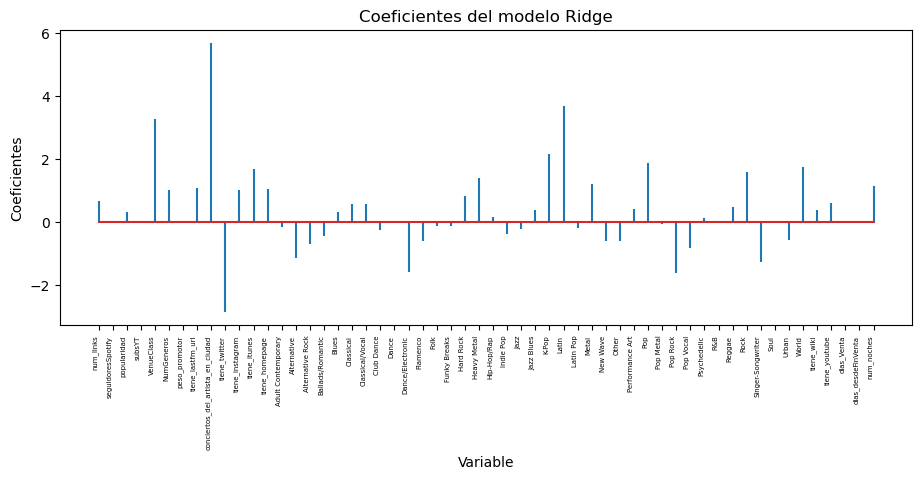

In [20]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame({
    'predictor': X.columns,
    'coef': ridgecv.best_estimator_.coef_
})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Ridge')
plt.show()


Pero si escalamos con Robust Scaler...

In [21]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'ridge__alpha': np.logspace(-5, 7, 200),
    'ridge__fit_intercept': [True],
}

    # Definir el ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', RobustScaler(), columnas_a_escalar)
        ],
        remainder='passthrough'  # Deja las otras columnas sin cambios
    )

# Crear el pipeline con el escalador y el modelo de regresión lineal
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

# Crear el objeto GridSearchCV
ridgecv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
ridgecv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(ridgecv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(len(np.unique(test_fold))):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", ridgecv.best_params_['ridge__alpha'])
    print("MSE (val):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (val):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (val):", -cv_results[f"split{i}_test_mape"].iloc[ridgecv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[ridgecv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[ridgecv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[ridgecv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[ridgecv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[ridgecv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[ridgecv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[ridgecv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Regularización ridge robust scaler', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 300.1835813575586
MSE (val): 190.66251699131587
RMSE (val): 13.808059856160671
MAPE (val): 0.32560195788177815
MSE (train): 198.90918597889697
RMSE (train): 14.103516794718152
MAPE (train): 0.2807041274739518

Pliegue 2:
Mejor valor de alpha: 300.1835813575586
MSE (val): 124.62464227378508
RMSE (val): 11.163540758817746
MAPE (val): 0.3320092168243387
MSE (train): 209.07997386777356
RMSE (train): 14.459597984306948
MAPE (train): 0.2915065810630464

Pliegue 3:
Mejor valor de alpha: 300.1835813575586
MSE (val): 358.1133861348295
RMSE (val): 18.92388401293005
MAPE (val): 0.23832687422521143
MSE (train): 152.73015938159278
RMSE (train): 12.358404402737142
MAPE (train): 0.27355485410411734

Pliegue 4:
Mejor valor de alpha: 300.1835813575586
MSE (val): 267.19933272403875
RMSE (val): 16.34623298267949
MAPE (val): 0.3410612095194756
MSE (train): 169.85723810220767
RMSE (train): 13.032928991681327
MAPE (train): 0.26797040749426165

Métricas promedio:
MSE promedi

| Métrica       | Mejor alpha | MSE (val) | RMSE (val) | MAPE (val) | MSE (train) | RMSE (train) | MAPE (train) |
|---------------|-------------|-----------|------------|------------|-------------|--------------|--------------|
| Iteración 1     | 300.1836    | 190.6625  | 13.8081    | 0.3256     | 198.9092    | 14.1035      | 0.2807       |
| Iteración 2     | 300.1836    | 124.6246  | 11.1635    | 0.3320     | 209.0800    | 14.4596      | 0.2915       |
| Iteración 3     | 300.1836    | 358.1134  | 18.9239    | 0.2383     | 152.7302    | 12.3584      | 0.2736       |
| Iteración 4     | 300.1836    | 267.1993  | 16.3462    | 0.3411     | 169.8572    | 13.0329      | 0.2680       |
| **Promedio**  | **300.1836**| **235.1500** | **15.0604** | **0.3092** | **182.6441**| **13.4886**  | **0.2784**   |


**Tiempo de ejecución**: 9.107917308807373 segundos


Y entonces los coeficientes de ajuste del modelo se verían afectados:

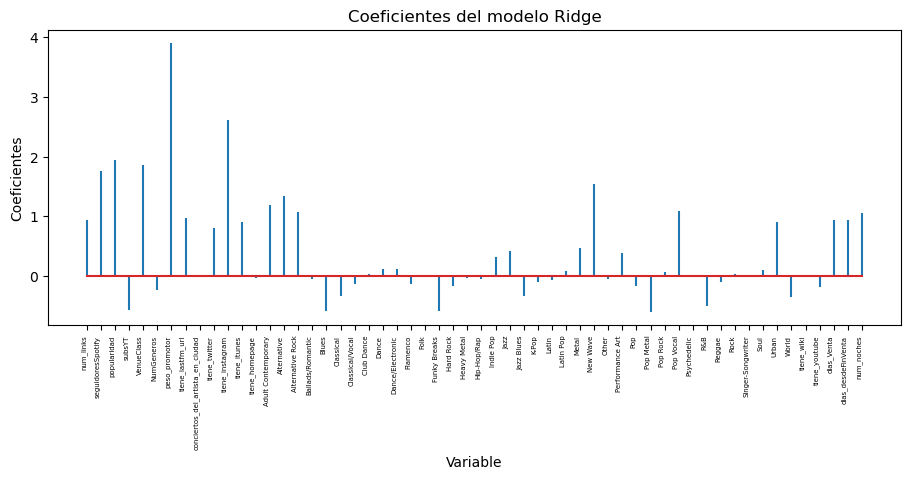

In [22]:
# Coeficientes del modelo Ridge
df_coeficientes = pd.DataFrame({
    'predictor': X.columns,
    'coef': ridgecv.best_estimator_.named_steps['ridge'].coef_
})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Ridge')
plt.show()

Aunque en este caso, el modelo Ridge sin escalar dé ligeramente mejor que escalando, hay que tener en cuenta que, **en regularización**, se emplee un método u otro, **siempre hay que estandarizar o normalizar los predictores**. Por eso mismo, Lasso y Elastic Net lo haremos directamente escalando con Robust Scaler.

### Lasso

In [23]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'lasso__alpha': np.logspace(-10, 3, 200),
    'lasso__fit_intercept': [True],
}

    # Definir el ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', RobustScaler(), columnas_a_escalar)
        ],
        remainder='passthrough'  # Deja las otras columnas sin cambios
    )

# Crear el pipeline con el escalador y el modelo Lasso
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
])

# Crear el objeto GridSearchCV
lassocv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
lassocv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(lassocv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(len(np.unique(test_fold))):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", lassocv.best_params_['lasso__alpha'])
    print("MSE (test):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[lassocv.best_index_])
    print("RMSE (test):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[lassocv.best_index_])
    print("MAPE (test):", -cv_results[f"split{i}_test_mape"].iloc[lassocv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[lassocv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[lassocv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[lassocv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[lassocv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[lassocv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[lassocv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[lassocv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[lassocv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[lassocv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Regularización laso mejor alpha', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 2.0970464013232393
MSE (test): 199.98411055478925
RMSE (test): 14.141573835849716
MAPE (test): 0.37031475346640663
MSE (train): 223.49335394075229
RMSE (train): 14.94969410860143
MAPE (train): 0.3192197004392603

Pliegue 2:
Mejor valor de alpha: 2.0970464013232393
MSE (test): 140.6821778051052
RMSE (test): 11.860951808565163
MAPE (test): 0.37076295326406167
MSE (train): 228.38175442541132
RMSE (train): 15.112304735724836
MAPE (train): 0.31326446853492507

Pliegue 3:
Mejor valor de alpha: 2.0970464013232393
MSE (test): 410.8540772433516
RMSE (test): 20.26953569382761
MAPE (test): 0.25910352695951433
MSE (train): 171.01224186502137
RMSE (train): 13.077164901652857
MAPE (train): 0.3102126756697095

Pliegue 4:
Mejor valor de alpha: 2.0970464013232393
MSE (test): 329.4839438690661
RMSE (test): 18.15169258964756
MAPE (test): 0.36566667242403816
MSE (train): 185.06291819424985
RMSE (train): 13.603783230934322
MAPE (train): 0.2976290020549484

Métricas promedi

| Métricas       | Mejor alpha | MSE (test) | RMSE (test) | MAPE (test) | MSE (train) | RMSE (train) | MAPE (train) |
|---------------|-------------|------------|-------------|-------------|-------------|--------------|--------------|
| Iteración 1     | 2.0970      | 199.9841   | 14.1416     | 0.3703      | 223.4934    | 14.9497      | 0.3192       |
| Iteración 2     | 2.0970      | 140.6822   | 11.8610     | 0.3708      | 228.3818    | 15.1123      | 0.3133       |
| Iteración 3     | 2.0970      | 410.8541   | 20.2695     | 0.2591      | 171.0122    | 13.0772      | 0.3102       |
| Iteración 4     | 2.0970      | 329.4839   | 18.1517     | 0.3657      | 185.0629    | 13.6038      | 0.2976       |
| **Promedio**  | **2.0970**  | **270.2511** | **16.1059** | **0.3415**  | **201.9876**| **14.1857**  | **0.3101**   |


**Tiempo de ejecución**: 13.773720026016235 segundos


Y si calculamos los coeficientes que mejor se ajustan al modelo:

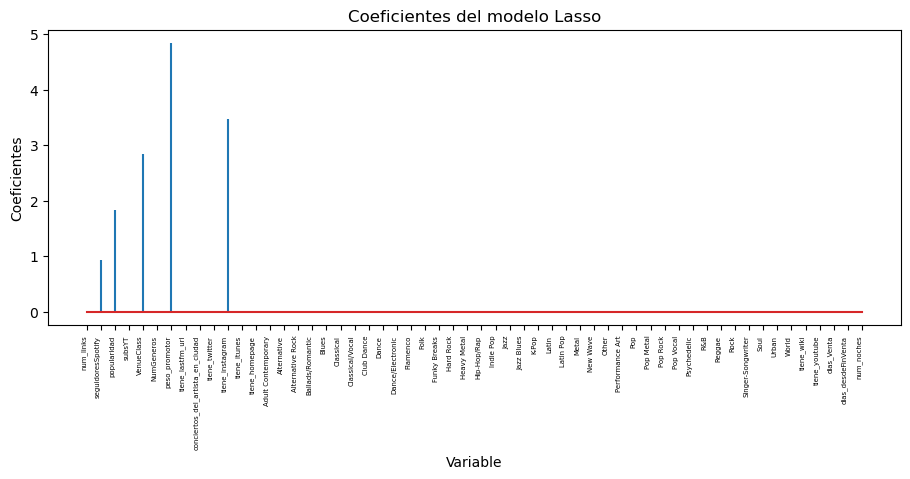

In [24]:
# Coeficientes del modelo
lasso_coef = lassocv.best_estimator_.named_steps['lasso'].coef_
predictor_names = X.columns

df_coeficientes = pd.DataFrame({
    'predictor': predictor_names,
    'coef': lasso_coef
})

# Plot de los coeficientes
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Lasso')
plt.show()


### Elastic Net

Nota: El siguiente código tarda en ejecutarse 2 minutos y medio.

In [25]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np
import time

# Definir la función para el cálculo del MAPE
def mape_scorer(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Definir los scorers
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',  # MSE
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',  # RMSE
    'mape': make_scorer(mape_scorer, greater_is_better=False)  # MAPE
}

# Definir el array test_fold a partir de la columna 'folds'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir los parámetros a buscar
param_grid = {
    'elastic_net__alpha': np.logspace(-10, 3, 200),
    'elastic_net__l1_ratio': [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
    'elastic_net__fit_intercept': [True],
}

    # Definir el ColumnTransformer
preprocessor = ColumnTransformer(
        transformers=[
            ('scaler', RobustScaler(), columnas_a_escalar)
        ],
        remainder='passthrough'  # Deja las otras columnas sin cambios
    )

# Crear el pipeline con el escalador y el modelo ElasticNet
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet())
])

# Crear el objeto GridSearchCV
elastic_net_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=ps, scoring=scoring, refit='neg_mean_squared_error', return_train_score=True)

# Tiempo de ejecución
start_time = time.time()

# Entrenar el modelo con GridSearchCV
elastic_net_cv.fit(X, y)

# Obtener los resultados de la validación cruzada
cv_results = pd.DataFrame(elastic_net_cv.cv_results_)

# Calcular tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time

# Imprimir los resultados de cada iteración
for i in range(len(np.unique(test_fold))):  # Se itera sobre los pliegues
    print(f"\nPliegue {i + 1}:")
    print("Mejor valor de alpha:", elastic_net_cv.best_params_['elastic_net__alpha'])
    print("Mejor valor de l1_ratio:", elastic_net_cv.best_params_['elastic_net__l1_ratio'])
    print("MSE (test):", -cv_results[f"split{i}_test_neg_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("RMSE (test):", -cv_results[f"split{i}_test_neg_root_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("MAPE (test):", -cv_results[f"split{i}_test_mape"].iloc[elastic_net_cv.best_index_])
    print("MSE (train):", -cv_results[f"split{i}_train_neg_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("RMSE (train):", -cv_results[f"split{i}_train_neg_root_mean_squared_error"].iloc[elastic_net_cv.best_index_])
    print("MAPE (train):", -cv_results[f"split{i}_train_mape"].iloc[elastic_net_cv.best_index_])

# Calcular las métricas promedio de train y de validación
mean_mse_train = -cv_results['mean_train_neg_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_rmse_train = -cv_results['mean_train_neg_root_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_mape_train = -cv_results['mean_train_mape'].iloc[elastic_net_cv.best_index_]
mean_mse = -cv_results['mean_test_neg_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_rmse = -cv_results['mean_test_neg_root_mean_squared_error'].iloc[elastic_net_cv.best_index_]
mean_mape = -cv_results['mean_test_mape'].iloc[elastic_net_cv.best_index_]

# Imprimir las métricas promedio
print("\nMétricas promedio:")
print("MSE promedio (train):", mean_mse_train, " ,  MSE promedio (val):", mean_mse)
print("RMSE promedio (train):", mean_rmse_train, " ,  RMSE promedio (val):", mean_rmse)
print("MAPE promedio (train):", mean_mape_train, " ,  MAPE promedio (val):", mean_mape)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")
# Cargar el modelo en mlflow
cargar_modelo_mlflow(modelo, 'MIN_PRICE', 'Regularización elastic mejor alpha y lambda', cv_results, execution_time)


Pliegue 1:
Mejor valor de alpha: 0.7316807143427208
Mejor valor de l1_ratio: 0
MSE (test): 187.42815280937344
RMSE (test): 13.690440197793986
MAPE (test): 0.3226995209136229
MSE (train): 196.1764263084738
RMSE (train): 14.006299522303305
MAPE (train): 0.27760355437566725

Pliegue 2:
Mejor valor de alpha: 0.7316807143427208
Mejor valor de l1_ratio: 0
MSE (test): 124.39394880407153
RMSE (test): 11.153203522041169
MAPE (test): 0.3284418548846207
MSE (train): 206.43123176498327
RMSE (train): 14.367714911042162
MAPE (train): 0.28802123882335784

Pliegue 3:
Mejor valor de alpha: 0.7316807143427208
Mejor valor de l1_ratio: 0
MSE (test): 356.17840411880974
RMSE (test): 18.872689371650498
MAPE (test): 0.23714307844832505
MSE (train): 150.53550419528938
RMSE (train): 12.269291104024282
MAPE (train): 0.27006599120001246

Pliegue 4:
Mejor valor de alpha: 0.7316807143427208
Mejor valor de l1_ratio: 0
MSE (test): 272.3284330163256
RMSE (test): 16.502376586913947
MAPE (test): 0.3375323409821577
MSE 

|        | Mejor alpha | Mejor l1_ratio | MSE (test) | RMSE (test) | MAPE (test) | MSE (train) | RMSE (train) | MAPE (train) |
|---------------|-------------|----------------|------------|-------------|-------------|-------------|--------------|--------------|
| Iteración 1     | 0.7317      | 0              | 187.4282   | 13.6904     | 0.3227      | 196.1764    | 14.0063      | 0.2776       |
| Iteración 2     | 0.7317      | 0              | 124.3939   | 11.1532     | 0.3284      | 206.4312    | 14.3677      | 0.2880       |
| Iteración 3     | 0.7317      | 0              | 356.1784   | 18.8727     | 0.2371      | 150.5355    | 12.2693      | 0.2701       |
| Iteración 4     | 0.7317      | 0              | 272.3284   | 16.5024     | 0.3375      | 166.6419    | 12.9090      | 0.2644       |
| **Promedio**  | **0.7317**  | **0**          | **235.0822** | **15.0547** | **0.3065**  | **179.9463**| **13.3881**  | **0.2750**   |


**Tiempo de ejecución**: 125.3728334903717 segundos


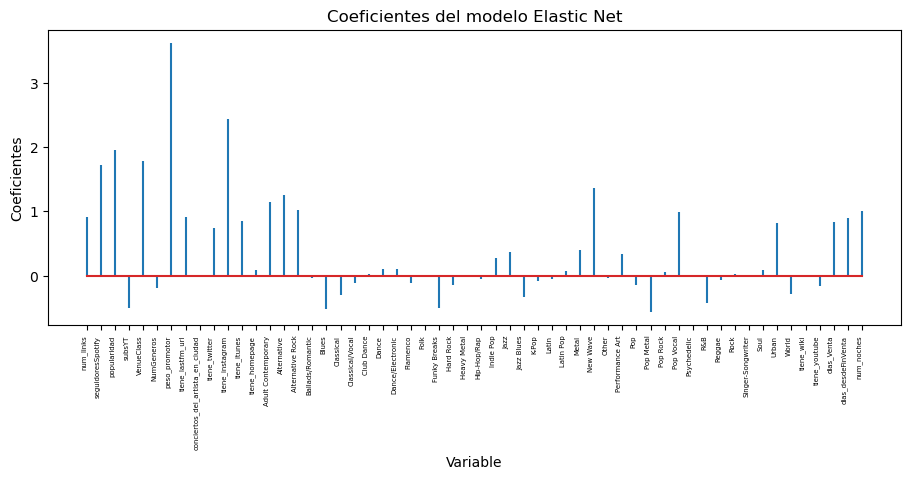

In [26]:
# Coeficientes del modelo ElasticNet
df_coeficientes = pd.DataFrame({
    'predictor': X.columns,
    'coef': elastic_net_cv.best_estimator_.named_steps['elastic_net'].coef_
})

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo Elastic Net')
plt.show()


--------------------------

-------------------

## RESULTADOS FINALES

Comparando todos los modelos implementados en este script para *regresión lineal*:

|                 | MB sin escalar        | MB sin escalar con numéricas   | MB SS   | MB RS   | MB CT   | GridSearch   | RandomSearch   | Ridge sin escalar | Ridge RS         |Lasso RS        |Elastic Net RS        |
|------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| MAPE promedio (val)    | 0.3198    | 0.3300    | 50114286888.274155 | 0.3198    | -         | 0.3225    | 0.3225    | 0.2884    | 0.3092    | 0.3415    | 0.3065    |
| MSE promedio (val)     | 367.8249  | 346.6996  | 1.3617429416152557e+26 | 367.8249  | -         | 365.6928  | 365.6928  | 307.0149  | 235.1500  | 270.2511  | 235.0822  |
| RMSE promedio (val)    | 18.5675   | 18.0092   | 6615428360390.157 | 18.5675   | 18.5675   | 18.4844   | 18.4844   | 16.8213   | 16.1059   | 16.1060   | 15.0547   |
| Tiempo de ejecución    | 0.0730    | 0.0276    | 0.0700    | 0.0250    | 0.0680    | 0.1188    | 0.1083    | 4.4632    | 9.1079    | 13.7737   | 125.3728  |
| Mejor alpha            | -         | -         | -         | -         | -         | -         | -         | 65.1734   | 300.1836  | 2.0970    | 0.7317    |
| Mejor l1_ratio         | -         | -         | -         | -         | -         | -         | -         | -         | -         | -         | 0         |


Siendo:

1) Modelo base sin escalar
2) Modelo base sin escalar solo con variables numéricas

--

3) Modelo base escalando con StandardScaler()
4) Modelo base escalando con RobustScaler()
5) Modelo base escalando con RobustScaler() y en pipeline usando ColumnTransformer()

--

6) Búsqueda en rejilla GridSearch
7) Búsqueda aleatoria RandomizedSearch

--

8) Regularización Ridge sin escalar
9) Regularización Ridge escalando con RobustScaler()
10) Regularización Lasso escalando con RobustScaler()
11) Regularización Elastic Net escalando con RobustScaler()

Observando los resultados, podemos notar lo siguiente:

- El modelo 3 muestra valores atípicos en las métricas de MAPE y MSE promedio (val), lo que sugiere que puede haber errores en el proceso de entrenamiento o validación.
- El modelo 5 carece de información sobre las métricas de MAPE y MSE promedio (val).
- Los modelos 8, 9, 10 y 11 tienen tiempos de ejecución notablemente más altos en comparación con los otros modelos.

Dado esto, podemos eliminar el modelo 3 debido a sus resultados atípicos y el modelo 5 debido a la falta de información relevante. Luego, podemos comparar los modelos restantes (1, 2, 4, 6, 7, 8, 9, 10 y 11) en términos de sus métricas y tiempos de ejecución.

Después de realizar una comparación detallada, el mejor modelo puede ser determinado por un equilibrio entre la precisión de las métricas y el tiempo de ejecución. Idealmente, elegiríamos el modelo con el MAPE, MSE y RMSE promedio más bajos en la validación, mientras se considera un tiempo de ejecución razonable.

Basándome en los resultados y considerando un equilibrio entre la precisión de las métricas y el tiempo de ejecución, elegiría el Modelo 2 como el mejor modelo.

Pero excluyendo este modelo (porque usa solo las variables numéricas), el mejor modelo podría ser el __Elastic Net con Robust Scaler__ (Elastic Net RS). Este modelo tiene un buen desempeño en términos de MAPE, MSE y RMSE promedio en la validación, con valores de 0.3065, 235.0822 y 15.0547 respectivamente. Además, su tiempo de ejecución es comparable al de otros modelos, lo que indica una eficiencia razonable en comparación con otros en la lista.

--------------------

## ANÁLISIS POR SEGMENTOS (VENUE CLASS) PARA ELASTIC NET ROBUST SCALER

In [27]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
import numpy as np

# Inicializar el RobustScaler solo con las columnas a escalar
scaler = RobustScaler()

# Escalar las características solo de las columnas especificadas
X_scaled = X.copy()
X_scaled[columnas_a_escalar] = scaler.fit_transform(X_scaled[columnas_a_escalar])

# Definir el modelo Elastic Net con el mejor alpha y l1_ratio
elastic_net = ElasticNet(alpha=0.7316807143427208, l1_ratio=0)

# Entrenar el modelo
elastic_net.fit(X_scaled, y)  # Considerando que y_min es tu variable de precio mínimo

# Generar predicciones
y_pred_min = elastic_net.predict(X_scaled)

# Añadir las predicciones al DataFrame original
datos['pred_min'] = y_pred_min

# Crear una lista para almacenar los resultados
resultados_min_list = []

# Calcular las métricas para cada valor de "VenueClass" en función de los precios mínimos
for vc in datos['VenueClass'].unique():
    subset = datos[datos['VenueClass'] == vc]
    mse_min = mean_squared_error(subset['min_price'], subset['pred_min'])
    rmse_min = np.sqrt(mse_min)
    mape_min = mean_absolute_percentage_error(subset['min_price'], subset['pred_min'])
    resultados_min_list.append({'VenueClass': vc, 'mse_min': mse_min, 'rmse_min': rmse_min, 'mape_min': mape_min})

# Convertir la lista de resultados en un DataFrame
resultados_min = pd.DataFrame(resultados_min_list)

# Imprimir los resultados
print("\nResultados por 'VenueClass' para el precio mínimo:")
print(resultados_min)



Resultados por 'VenueClass' para el precio mínimo:
   VenueClass     mse_min   rmse_min  mape_min
0           2  192.824537  13.886127  0.211163
1           3  456.722916  21.371077  0.292241
2           1  199.515612  14.125000  0.231584
3           0  167.790274  12.953388  0.310926


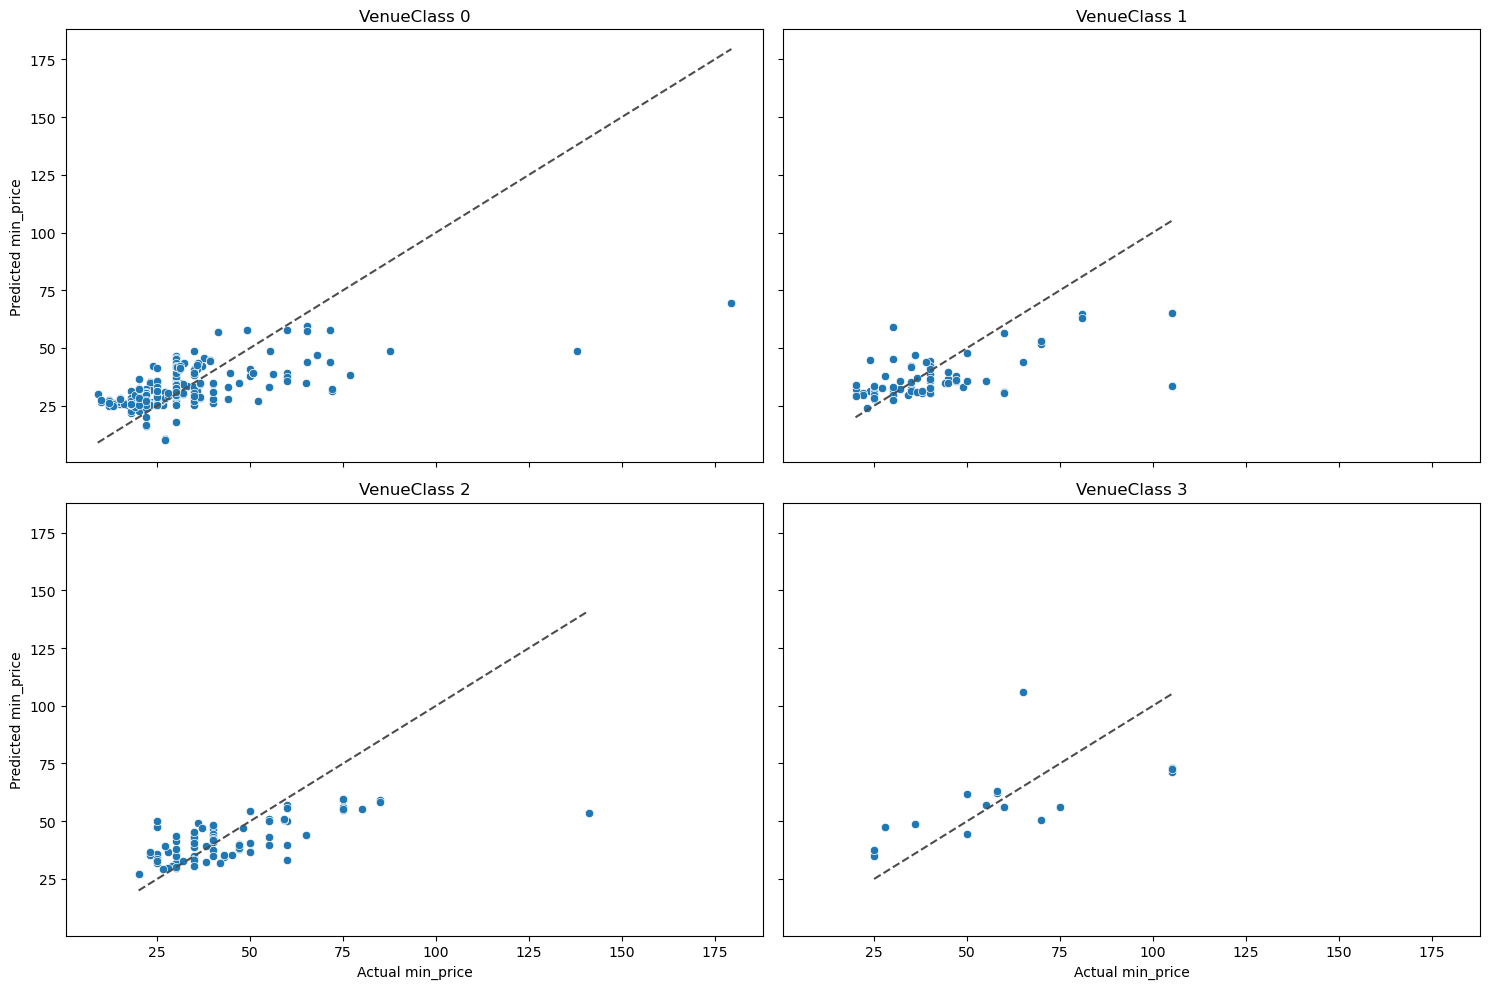

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráficos de dispersión para comparar predicciones con valores reales por cada "VenueClass" para el precio mínimo
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Asegurarnos de que los valores de 'VenueClass' están ordenados para una mejor visualización
venue_classes = sorted(datos['VenueClass'].unique())

for idx, vc in enumerate(venue_classes):
    subset = datos[datos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['min_price'], y=subset['pred_min'])
    ax.plot([subset['min_price'].min(), subset['min_price'].max()],
            [subset['min_price'].min(), subset['min_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual min_price')
    ax.set_ylabel('Predicted min_price')

plt.tight_layout()
plt.show()


In [29]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
import numpy as np

# Inicializar el RobustScaler
scaler = RobustScaler()

# Escalar las características solo de las columnas especificadas
X_scaled = X.copy()
X_scaled[columnas_a_escalar] = scaler.fit_transform(X_scaled[columnas_a_escalar])

# Definir el modelo Elastic Net con los valores de alpha y l1_ratio proporcionados
elastic_net = ElasticNet(alpha=0.7316807143427208, l1_ratio=0)

# Entrenar el modelo
elastic_net.fit(X_scaled, y)  # Asumiendo que 'y' es tu variable objetivo

# Generar predicciones
y_pred = elastic_net.predict(X_scaled)

# Añadir las predicciones al DataFrame original
datos['pred'] = y_pred

# Crear una lista para almacenar los resultados
resultados_list = []

# Mostrar ejemplos de los datos particionados por "VenueClass"
print(datos[['VenueClass', 'min_price', 'pred']].groupby('VenueClass').head())

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos['VenueClass'].unique():
    subset = datos[datos['VenueClass'] == vc]
    print(f"\nAnalizando 'VenueClass' {vc}")
    print(subset[['min_price', 'pred']].head())  # Mostrar los primeros ejemplos

    mse = mean_squared_error(subset['min_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['min_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'mse': mse, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)

# Imprimir los resultados
print("\nResultados por 'VenueClass':")
print(resultados)


    VenueClass  min_price       pred
0            2      28.00  36.596355
1            2      50.00  36.596355
2            3     105.00  71.540246
3            3     105.00  71.444881
4            3     105.00  72.915078
5            3     105.00  72.803820
6            1      20.00  29.768529
7            0      30.01  38.453262
8            0      30.01  37.935742
9            0      41.43  56.953853
10           0      49.11  57.739312
11           0      49.11  57.945934
12           3      50.00  44.544464
21           2      27.00  39.130167
24           1      25.00  30.655237
26           1      30.00  30.880546
31           2      40.00  43.028486
32           2      40.00  47.143392
34           1      24.00  31.560644
35           1      25.00  32.840112

Analizando 'VenueClass' 2
    min_price       pred
0        28.0  36.596355
1        50.0  36.596355
21       27.0  39.130167
31       40.0  43.028486
32       40.0  47.143392

Analizando 'VenueClass' 3
    min_price      

El modelo parece tener un rendimiento variable dependiendo de la clase de Venue considerada, con algunos grupos mostrando un rendimiento mejor que otros en términos de las métricas de evaluación utilizadas.

En este caso, lo que peor predice es la clase 3 (a diferencia de lo que pasaba con los precios máximos). Además, muestra un rendimiento similar a la clase 2, aunque con un error absoluto promedio ligeramente más alto.

En general, los errores entre las distintas clases son más parecidos entre sí que en el caso de los precios máximos. Aunque en ambos casos, la clase 3 despunte ya sea para bien o para mal.